In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
path = 'opencv-20220418-133240'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-18 13:32:40.950843,4.9,3591282688
1,2022-04-18 13:32:51.993342,45.8,2962640896
2,2022-04-18 13:33:03.050842,53.4,2930380800
3,2022-04-18 13:33:14.081842,47.4,2946760704
4,2022-04-18 13:33:25.151842,50.0,2946052096
5,2022-04-18 13:33:36.235842,54.3,3018383360
6,2022-04-18 13:33:47.267842,56.1,2996621312
7,2022-04-18 13:33:58.285843,51.7,2976161792
8,2022-04-18 13:34:09.666342,54.3,2878095360
9,2022-04-18 13:34:20.758842,53.1,2886287360


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

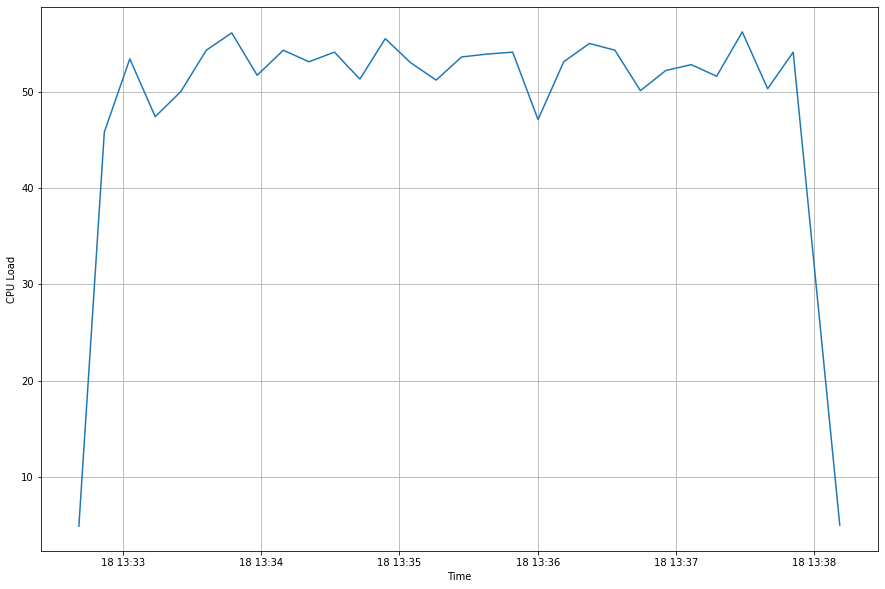

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

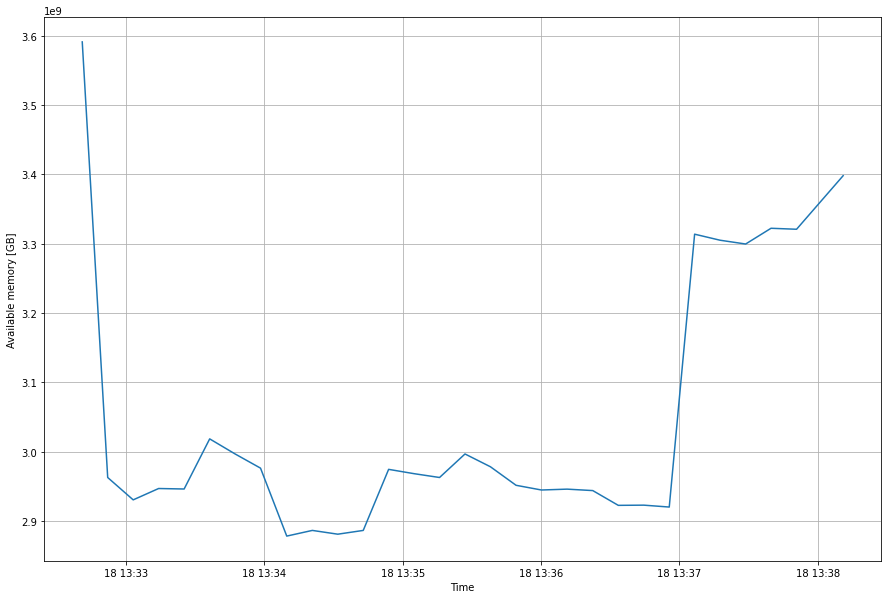

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

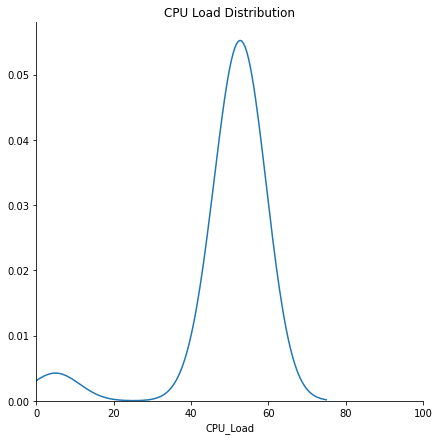

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

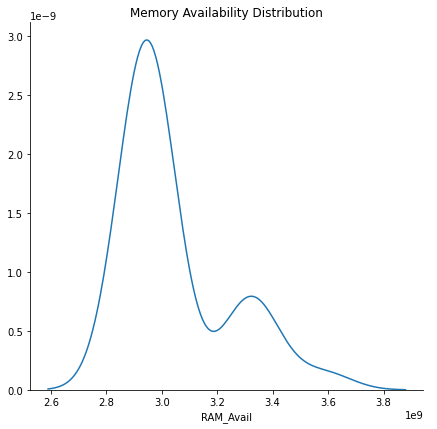

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-18 13:32:41.792342,384752900,0.750000,0.375000,0.500000,"[0.6699566160520607, 0.7114774889029803, 0.044...",3,1,5,8,"[(770.0, 196.0, 857.0, 283.0), (298.0, 156.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-18 13:32:41.882844,84283800,0.000000,0.000000,0.000000,[0.0],0,1,1,1,"[(417.0, 714.0, 737.0, 1034.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-18 13:32:41.965844,75658300,0.333333,0.500000,0.400000,"[0.6550373798504806, 0.0, 0.0]",1,2,1,2,"[(449.0, 40.0, 502.0, 93.0), (684.0, 322.0, 78...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-18 13:32:42.127343,75710900,0.000000,0.000000,0.000000,[],0,0,62,62,[],"[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-18 13:32:42.200843,57093000,0.833333,0.625000,0.714286,"[0.6420729029424681, 0.07943482963764197, 0.62...",5,1,3,8,"[(720.0, 63.0, 767.0, 110.0), (172.0, 6.0, 344...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-18 13:38:00.607843,135300100,1.000000,1.000000,1.000000,[0.6655021834061136],1,0,0,1,"[(460.0, 153.0, 622.0, 315.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-18 13:38:00.753844,138517800,1.000000,0.500000,0.666667,[0.6259521218715995],1,0,1,2,"[(690.0, 412.0, 808.0, 530.0)]","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-18 13:38:00.897842,81784900,1.000000,0.740741,0.851064,"[0.65625, 0.4759071980963712, 0.74074074074074...",20,0,7,27,"[(541.0, 379.0, 581.0, 419.0), (573.0, 319.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-18 13:38:00.960342,48729900,0.000000,0.000000,0.000000,[0.0],0,1,7,7,"[(290.0, 199.0, 393.0, 302.0)]","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,7.771942e+07,0.465523,0.384228,0.368819,1.663050,0.721017,10.645691,12.308741
std,3.187964e+07,0.434995,0.422700,0.381953,3.205457,1.046354,39.562287,39.822258
min,1.734560e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.712842e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.259960e+07,0.500000,0.179563,0.285714,1.000000,0.000000,2.000000,3.000000
75%,8.985500e+07,1.000000,1.000000,0.666667,2.000000,1.000000,7.000000,9.000000
max,4.728009e+08,1.000000,1.000000,1.000000,37.000000,8.000000,709.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,167,True,True,False
1,163,True,True,False
2,157,True,True,False
3,155,True,True,True
4,150,True,True,True
...,...,...,...,...
7686,6,False,False,False
7687,6,False,False,False
7688,6,False,False,False
7689,6,False,False,False


In [13]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [14]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,167,True,True,False,1.000000,0.000025,1.000000,0.000025,0.000000,0.000000
1,163,True,True,False,1.000000,0.000050,1.000000,0.000050,0.000000,0.000000
2,157,True,True,False,1.000000,0.000076,1.000000,0.000076,0.000000,0.000000
3,155,True,True,True,1.000000,0.000101,1.000000,0.000101,0.250000,0.000025
4,150,True,True,True,1.000000,0.000126,1.000000,0.000126,0.400000,0.000050
...,...,...,...,...,...,...,...,...,...,...
7686,6,False,False,False,0.697932,0.135111,0.664889,0.128715,0.135944,0.026317
7687,6,False,False,False,0.697841,0.135111,0.664802,0.128715,0.135926,0.026317
7688,6,False,False,False,0.697750,0.135111,0.664716,0.128715,0.135908,0.026317
7689,6,False,False,False,0.697659,0.135111,0.664629,0.128715,0.135891,0.026317


In [15]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

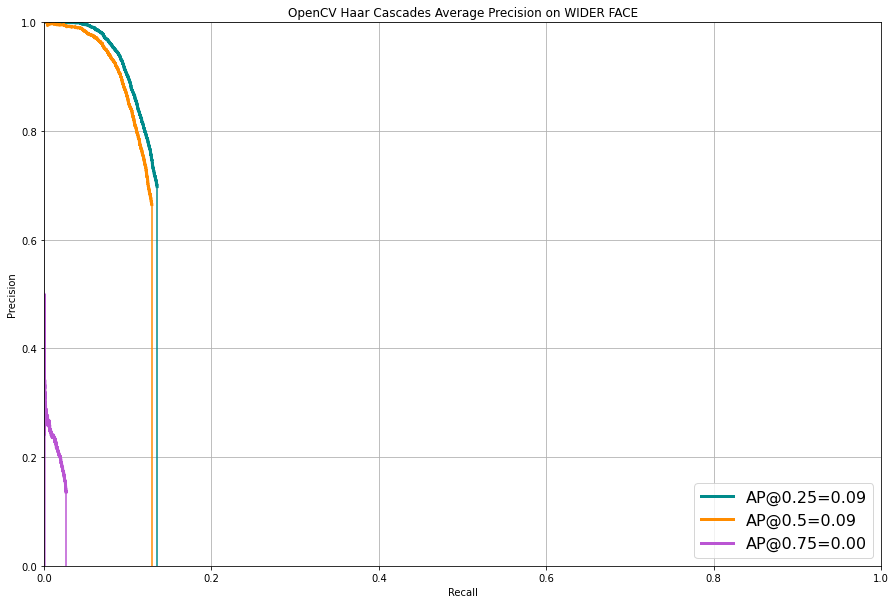

In [16]:
plot_pr(df_ap, 'OpenCV Haar Cascades Average Precision on WIDER FACE')